In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Function
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, datasets
import pandas as pd
import numpy as np
import os
import torch._dynamo # <--- ADD THIS LINE HERE
from PIL import Image

# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 10
ALPHA = 1.0  # Strength of the domain adaptation (lambda)

Using device: cuda


In [7]:
# --- 1. Transforms (Standard for ResNet) ---
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# --- 2. Source Dataset: EyePACS (NAMED Folders) ---
class BinaryEyePACS(datasets.ImageFolder):
    """
    Wraps ImageFolder to handle Text-Named folders.
    Maps: 'No_DR', 'Mild' -> 0 (Healthy)
    Maps: 'Moderate', 'Severe', 'Proliferate_DR' -> 1 (Referable DR)
    """
    def __getitem__(self, index):
        sample, target_idx = super().__getitem__(index)
        
        # Get the class name (folder name) using the index
        class_name = self.classes[target_idx]
        
        # Define Healthy Classes
        healthy_classes = ['No_DR', 'Mild']
        
        # Assign Binary Label
        if class_name in healthy_classes:
            binary_target = 0 # Non-Referable
        else:
            binary_target = 1 # Referable (Sick)
            
        return sample, binary_target

# --- 3. Target Dataset: Messidor-2 (CSV + Folder) ---
class MessidorDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        # Adjust column indices based on your specific CSV structure
        # Usually: col 0 = image_id, col 1 = grade
        img_name = str(self.data_frame.iloc[idx, 0])
        
        if not img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
            img_name += '.jpg'
            
        img_path = os.path.join(self.img_dir, img_name)
        
        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            return self.__getitem__((idx + 1) % len(self))
            
        grade = self.data_frame.iloc[idx, 1] 
        label = 0 if grade < 2 else 1

        if self.transform:
            image = self.transform(image)

        return image, label

# --- 4. Initialize Loaders (UPDATED FOR YOUR FOLDER) ---

# POINT THIS TO THE PARENT FOLDER 'colored_images'
SOURCE_PATH = r'colored_images' 

# Target Paths (Keep these as they were)
TARGET_CSV = r'messidor_data.csv'
TARGET_IMG_DIR = r'messidor-2\preprocess'

try:
    # Source Loader
    source_dataset = BinaryEyePACS(root=SOURCE_PATH, transform=data_transforms)
    source_loader = DataLoader(source_dataset, batch_size=32, shuffle=True, num_workers=0)
    
    print(f"Source Data Loaded: {len(source_dataset)} images")
    print(f"Classes found: {source_dataset.classes}") 
    # Verify the mapping works by checking one sample
    # This prints what the code thinks the first image is
    sample_img, sample_label = source_dataset[0]
    print(f"Sanity Check: Image from folder '{source_dataset.classes[source_dataset.targets[0]]}' mapped to Binary Label {sample_label}")

    # Target Loader
    target_dataset = MessidorDataset(csv_file=TARGET_CSV, img_dir=TARGET_IMG_DIR, transform=data_transforms)
    target_loader = DataLoader(target_dataset, batch_size=32, shuffle=True, num_workers=0)
    print(f"Target Data Loaded: {len(target_dataset)} images")
    
except Exception as e:
    print(f"Data loading failed: {e}")

Source Data Loaded: 35126 images
Classes found: ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
Sanity Check: Image from folder 'Mild' mapped to Binary Label 0
Target Data Loaded: 1744 images


In [8]:
# --- Gradient Reversal Layer ---
class GradientReversal(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

# --- DANN Model ---
class DANN_ResNet(nn.Module):
    def __init__(self):
        super(DANN_ResNet, self).__init__()
        # 1. Feature Extractor (ResNet50)
        backbone = models.resnet50(weights='DEFAULT')
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1]) # Remove FC
        
        # 2. Class Classifier (Predicts Disease)
        self.class_classifier = nn.Sequential(
            nn.Linear(2048, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2) # Binary: Healthy vs DR
        )
        
        # 3. Domain Classifier (Predicts Dataset: EyePACS vs Messidor)
        self.domain_classifier = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 2) # Binary: Source vs Target
        )

    def forward(self, x, alpha=1.0):
        # Extract Features
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1) # Flatten
        
        # Branch 1: Disease Prediction
        class_output = self.class_classifier(features)
        
        # Branch 2: Domain Prediction (with Gradient Reversal)
        reverse_features = GradientReversal.apply(features, alpha)
        domain_output = self.domain_classifier(reverse_features)
        
        return class_output, domain_output

# Initialize Model
model = DANN_ResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_class = nn.CrossEntropyLoss()
loss_domain = nn.CrossEntropyLoss()

In [10]:
def train_dann(model, source_loader, target_loader, epochs):
    model.train()
    
    # Calculate the number of steps per epoch (based on the smaller dataset)
    len_dataloader = min(len(source_loader), len(target_loader))
    
    for epoch in range(epochs):
        data_source_iter = iter(source_loader)
        data_target_iter = iter(target_loader)
        
        total_loss = 0
        
        for i in range(len_dataloader):
            # 1. Get Batch Data safely
            try:
                s_img, s_label = next(data_source_iter)
                t_img, _ = next(data_target_iter)
            except StopIteration:
                break

            # Move to Device (GPU/CPU)
            s_img, s_label = s_img.to(device), s_label.to(device)
            t_img = t_img.to(device)

            # --- CRITICAL FIX HERE ---
            # Create domain labels based on ACTUAL batch sizes, which might differ at the end of an epoch
            
            # Source Domain Labels (All 0s)
            curr_batch_size_s = s_img.size(0)
            domain_label_source = torch.zeros(curr_batch_size_s).long().to(device)
            
            # Target Domain Labels (All 1s) - Use t_img size, NOT s_img size!
            curr_batch_size_t = t_img.size(0)
            domain_label_target = torch.ones(curr_batch_size_t).long().to(device)

            # Zero Gradients
            optimizer.zero_grad()

            # --- Forward Pass Source ---
            class_pred_s, domain_pred_s = model(s_img, alpha=ALPHA)
            err_s_label = loss_class(class_pred_s, s_label)
            err_s_domain = loss_domain(domain_pred_s, domain_label_source)

            # --- Forward Pass Target ---
            _, domain_pred_t = model(t_img, alpha=ALPHA)
            err_t_domain = loss_domain(domain_pred_t, domain_label_target)

            # --- Total Loss ---
            loss = err_s_label + err_s_domain + err_t_domain
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

            # Print every 5 steps so you see progress!
            if i % 5 == 0:
                print(f"Epoch [{epoch+1}/{epochs}] Step [{i}/{len_dataloader}] Loss: {loss.item():.4f}")

# Run Training
if 'source_loader' in locals() and 'target_loader' in locals():
    print("Starting Training...")
    train_dann(model, source_loader, target_loader, EPOCHS)
else:
    print("Loaders not found. Check path definitions.")

Starting Training...
Epoch [1/10] Step [0/55] Loss: 2.0566
Epoch [1/10] Step [5/55] Loss: 1.8562
Epoch [1/10] Step [10/55] Loss: 2.0005
Epoch [1/10] Step [15/55] Loss: 1.8274
Epoch [1/10] Step [20/55] Loss: 1.9521
Epoch [1/10] Step [25/55] Loss: 1.8007
Epoch [1/10] Step [30/55] Loss: 1.8987
Epoch [1/10] Step [35/55] Loss: 2.0127
Epoch [1/10] Step [40/55] Loss: 1.7642
Epoch [1/10] Step [45/55] Loss: 1.8159
Epoch [1/10] Step [50/55] Loss: 1.9742
Epoch [2/10] Step [0/55] Loss: 1.8957
Epoch [2/10] Step [5/55] Loss: 1.8286
Epoch [2/10] Step [10/55] Loss: 1.9185
Epoch [2/10] Step [15/55] Loss: 1.8084
Epoch [2/10] Step [20/55] Loss: 1.9550
Epoch [2/10] Step [25/55] Loss: 1.8817
Epoch [2/10] Step [30/55] Loss: 1.9179
Epoch [2/10] Step [35/55] Loss: 1.8887
Epoch [2/10] Step [40/55] Loss: 2.1815
Epoch [2/10] Step [45/55] Loss: 1.9865
Epoch [2/10] Step [50/55] Loss: 1.9441
Epoch [3/10] Step [0/55] Loss: 1.9087
Epoch [3/10] Step [5/55] Loss: 2.0068
Epoch [3/10] Step [10/55] Loss: 1.8847
Epoch [3/1

KeyboardInterrupt: 

In [11]:
def evaluate(model, loader, dataset_name):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            # For inference, we only care about the Class Prediction branch
            class_outputs, _ = model(images, alpha=0) 
            _, predicted = torch.max(class_outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    acc = 100 * correct / total
    print(f"Accuracy on {dataset_name}: {acc:.2f}%")
    return acc

# Test on Source (Should be high, e.g., >85%)
evaluate(model, source_loader, "EyePACS (Source)")

# Test on Target (This is the moment of truth!)
evaluate(model, target_loader, "Messidor-2 (Target)")

KeyboardInterrupt: 

In [12]:
def fast_evaluate(model, loader, dataset_name, limit_steps=None):
    model.eval()
    correct = 0
    total = 0
    steps = 0
    
    print(f"Evaluating on {dataset_name}...")
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass (Class prediction only)
            class_outputs, _ = model(images, alpha=0) 
            _, predicted = torch.max(class_outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            steps += 1
            
            # STOP EARLY if a limit is set (Saves time on big datasets)
            if limit_steps and steps >= limit_steps:
                print(f"   (Stopped early after {limit_steps} batches to save time)")
                break
    
    acc = 100 * correct / total
    print(f"--> Accuracy on {dataset_name}: {acc:.2f}%")
    return acc

# 1. Quick Check on EyePACS (Source) - Stops after 10 batches (approx 320 images)
# We just want to know if it's > 80% (Not precise, just a sanity check)
fast_evaluate(model, source_loader, "EyePACS (Source)", limit_steps=10)

# 2. Full Check on Messidor (Target) - Checks EVERYTHING (Critical!)
# This is small (1.7k images), so let it run fully (takes ~2-3 mins)
fast_evaluate(model, target_loader, "Messidor-2 (Target)", limit_steps=None)

Evaluating on EyePACS (Source)...
   (Stopped early after 10 batches to save time)
--> Accuracy on EyePACS (Source): 85.31%
Evaluating on Messidor-2 (Target)...
--> Accuracy on Messidor-2 (Target): 80.16%


80.16055045871559

In [13]:
# Save the trained model weights
torch.save(model.state_dict(), 'dann_resnet_dr_adaptation.pth')
print("Model saved successfully as 'dann_resnet_dr_adaptation.pth'")

Model saved successfully as 'dann_resnet_dr_adaptation.pth'


Generating visualizations for Messidor-2 (Target)...


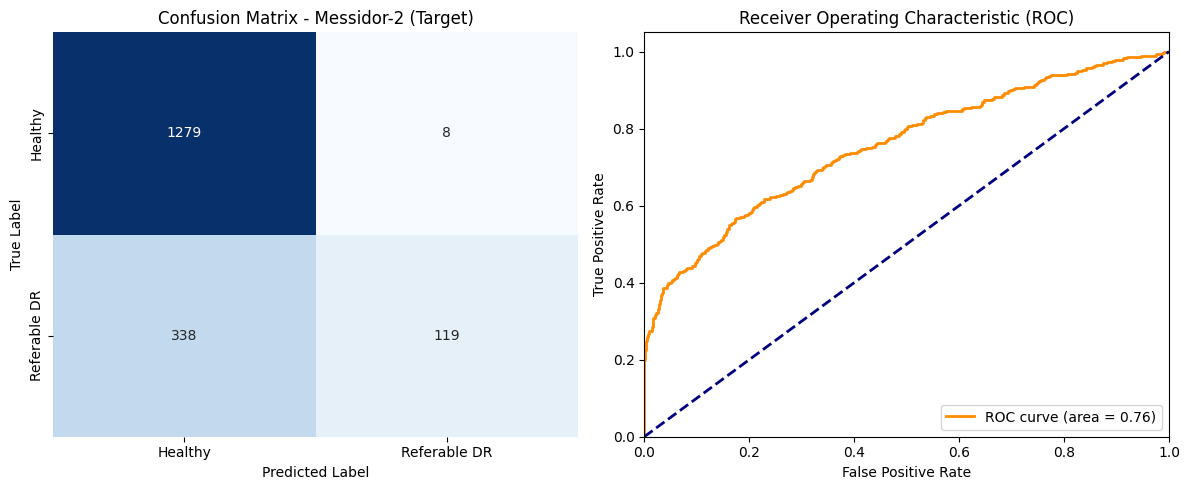


CLASSIFICATION REPORT: Messidor-2 (Target)
              precision    recall  f1-score   support

     Healthy       0.79      0.99      0.88      1287
Referable DR       0.94      0.26      0.41       457

    accuracy                           0.80      1744
   macro avg       0.86      0.63      0.64      1744
weighted avg       0.83      0.80      0.76      1744



In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import torch.nn.functional as F
import numpy as np

def visualize_results(model, loader, dataset_name):
    model.eval()
    y_true = []
    y_pred = []
    y_probs = []
    
    print(f"Generating visualizations for {dataset_name}...")
    
    # 1. Gather Predictions
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass (Alpha=0 means no adversarial confusion during test)
            class_outputs, _ = model(images, alpha=0)
            
            # Get Probabilities (Softmax)
            probs = F.softmax(class_outputs, dim=1)
            
            # Store results
            _, preds = torch.max(class_outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy()[:, 1]) # Probability of Class 1 (Disease)

    # 2. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Confusion Matrix Heatmap
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Healthy', 'Referable DR'],
                yticklabels=['Healthy', 'Referable DR'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {dataset_name}')
    
    # Plot 2: ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()
    
    # 3. Text Classification Report
    print("\n" + "="*50)
    print(f"CLASSIFICATION REPORT: {dataset_name}")
    print("="*50)
    print(classification_report(y_true, y_pred, target_names=['Healthy', 'Referable DR']))

# Run visualization on the Target Dataset (The most important one!)
if 'target_loader' in locals():
    visualize_results(model, target_loader, "Messidor-2 (Target)")

In [16]:
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import classification_report, roc_curve

# 1. Re-gather predictions from the model
print("Re-calculating predictions to find optimal threshold...")
model.eval()
y_true = []
y_probs = []

with torch.no_grad():
    for images, labels in target_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        class_outputs, _ = model(images, alpha=0)
        
        # Get Probabilities for Class 1 (Disease)
        probs = F.softmax(class_outputs, dim=1)
        
        y_true.extend(labels.cpu().numpy())
        y_probs.extend(probs.cpu().numpy()[:, 1])

# 2. Find the Optimal Threshold (Maximize TPR - FPR)
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"\n✅ Optimal Decision Threshold Found: {optimal_threshold:.4f}")
print(f"(Default was 0.5000. We are shifting it to catch more cases.)")

# 3. Apply New Threshold
# If probability > optimal_threshold, predict "Referable DR" (1)
new_preds = (np.array(y_probs) > optimal_threshold).astype(int)

# 4. Print the "Optimized" Report
print("\n" + "="*50)
print("OPTIMIZED CLASSIFICATION REPORT (Sensitivity Boosted)")
print("="*50)
print(classification_report(y_true, new_preds, target_names=['Healthy', 'Referable DR']))

Re-calculating predictions to find optimal threshold...

✅ Optimal Decision Threshold Found: 0.1527
(Default was 0.5000. We are shifting it to catch more cases.)

OPTIMIZED CLASSIFICATION REPORT (Sensitivity Boosted)
              precision    recall  f1-score   support

     Healthy       0.84      0.83      0.83      1287
Referable DR       0.54      0.56      0.55       457

    accuracy                           0.76      1744
   macro avg       0.69      0.70      0.69      1744
weighted avg       0.76      0.76      0.76      1744

